# POS Steady-State Modelling

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
lineS = [0, 35]
Cmin = 20
Cmax = 40

In [3]:
msrS = [0,2,5,6,8,10,22,23,25,27]
msrC = [40, 30, 27, 26,22,24,29,25,22,21]

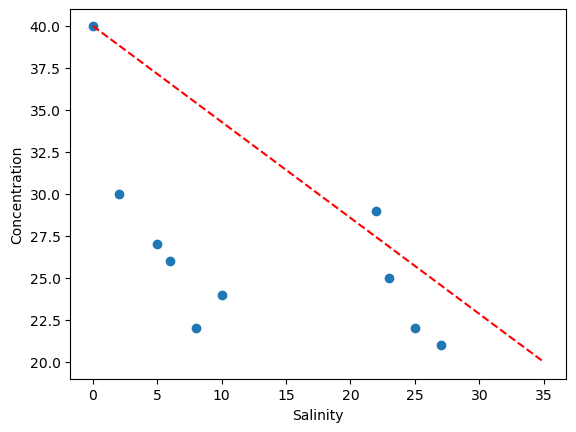

In [4]:
plt.plot(lineS, [Cmax, Cmin], c='r', linestyle = '--')
plt.scatter(msrS, msrC)
plt.xlabel('Salinity')
plt.ylabel('Concentration')
plt.show()

# relationship of Weiss and Price (1980).
Determine the N$_2$0 saturation. https://doi.org/10.1016/0304-4203(80)90024-9

## Constante

In [60]:
def weiss_relation(P,T,S) :
    

    TK = 273.15
    T += TK
    #S = 35
    x = 336*10**-9
    
    A1 = -165.8806  
    A2 = 222.8743
    A3 = 92.0792
    A4 = -1.48425
    B1 = - 0.056235
    B2 = 0.031619 
    B3 = - 0.0048472 

    F = A1 + A2*(100/T) + A3*np.log(T/100) + A4*(T/100)**2 + S*(B1 + B2*(T/100) + B3*(T/100)**2)
    F = np.exp(F)
    
    C = x * F
    print(C, 'mol.L')
    
    return C

In [62]:
C = weiss_relation(1, 5,35)

1.3120445987921935e-08 mol.L


### Calculating the concentration

In [63]:
'''
M = N2O measurement in mol.L**-1
t = Temperature in celcius
S = Salinity in PSU
u = wind speed (m/s)
A = surface area (default = 1 m**2)
P = Pressure (1 atm)
'''

def Wanninkhof(M, t, S, u=5, A=1, P=1) :

    kw = 2.0 + 0.24*u**2
    Sc = 2301.1 - 151.1*t + 4.7364*t**2 - 0.059431*t**3 #Wanninkhof 1992

    k = kw * (Sc/600)**-.5 #in cm/hour
    k = k/((3600)*100) #convert into m/s
    
    C = weiss_relation(P, t, S)
    
    
    F = k*A*((M-C)*1000) #*1000 to convert in m^3
    
    print(F*60*60*24*10**6, 'µmol/m²/day')
    print(F, 'mol/m²/s')
    return F 

In [64]:
Wanninkhof(70*10**-9,10,35)

1.0923494738310538e-08 mol.L
80.06130856108727 µmol/m²/day
9.266355157533249e-10 mol/m²/s


9.266355157533249e-10

### Importing temperature, salinity and [N2O] data

In [36]:
root = 'D:/GitHub/PlanktonOfSchelde/'

In [86]:
df = pd.read_csv(root+'data/GC-DATA.csv', delimiter=';', decimal=',')

In [87]:
df

,Station,Tmean (°C),Salinity PSU,N2O (nM),NH4 (µmol/L),NOx (µmol/L)
0,S01,7.00,27.81,15.23,5.98,104.17
1,S01B,6.90,29.70,18.03,4.97,61.85
2,T02,7.64,8.05,-999.00,16.00,87.10
3,S04,6.89,22.38,19.40,5.72,133.47
4,T04,6.71,16.17,22.43,8.95,179.04
5,T05,6.60,18.77,-999.00,7.94,157.88
6,S09,7.29,11.04,27.88,5.61,231.12
7,S12,7.58,6.64,33.88,24.47,274.70
8,S15,7.59,8.89,29.41,10.38,259.63
9,S15B,7.26,3.79,40.29,15.41,291.45


In [90]:
Tmeas = df['Tmean (°C)']
Smeas = df['Salinity PSU']
Nmeas = df['N2O (nM)']
Nhmeas = df['NH4 (µmol/L)']
NOmeas = df['NOx (µmol/L)'] 
NmeasNan = np.where(Nmeas == -999, np.nan, Nmeas)
NhmeasNan = np.where(Nhmeas == -999, np.nan, Nhmeas)
NOmeasNan = np.where(NOmeas == -999, np.nan, NOmeas)

In [66]:
Nmeas

0      15.23
1      18.03
2    -999.00
3      19.40
4      22.43
5    -999.00
6      27.88
7      33.88
8      29.41
9      40.29
10     43.58
11     74.40
12     22.37
13     23.00
14     20.71
Name: N2O (nM), dtype: float64

Text(0, 0.5, '[N$_2$O] nmol.L$^{-1}$')

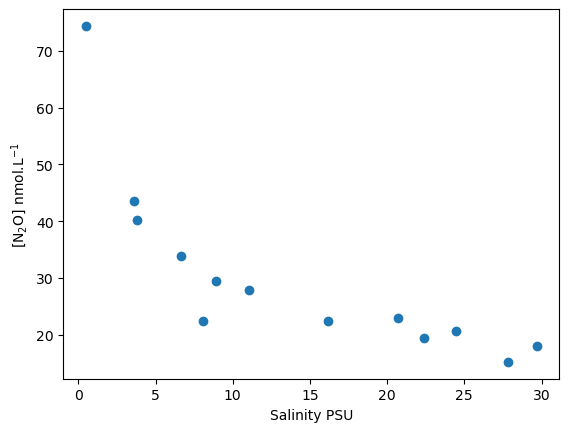

In [93]:
plt.scatter(Smeas, NmeasNan)
plt.xlabel('Salinity PSU')
plt.ylabel('[N$_2$O] nmol.L$^{-1}$')

Text(0, 0.5, '[N$_2$O] nmol.L$^{-1}$')

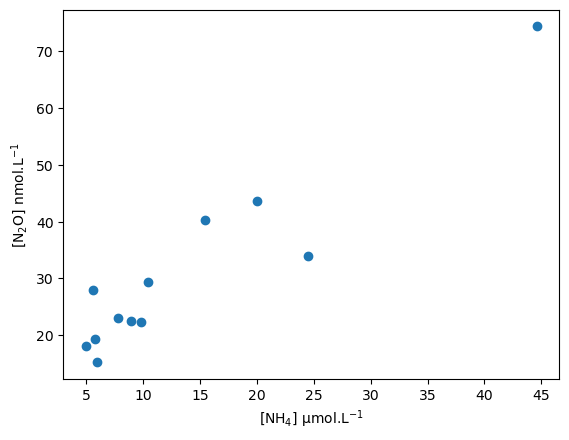

In [97]:
plt.scatter(NhmeasNan, NmeasNan)
plt.xlabel('[NH$_4$] µmol.L$^{-1}$')
plt.ylabel('[N$_2$O] nmol.L$^{-1}$')

### Computing the N2O fluxes

In [99]:
Flux = []
for i in range(len(Tmeas)) :

    N2O = Nmeas[i]
    temp = Tmeas[i]
    Sali = Smeas[i]

    if N2O != -999 :
        N2O = Nmeas[i]*10**-9
        f = Wanninkhof(N2O,temp,Sali)
        f = f*24*3600*10**6 #convert in µmol.m**-2.day**-1
        Flux.append(f) 
    else :
        Flux.append(-999)

1.2683158225232332e-08 mol.L
3.140021215164178 µmol/m²/day
3.6342838138474284e-11 mol/m²/s
1.2594036426656316e-08 mol.L
6.680526981815701 µmol/m²/day
7.732091414138543e-11 mol/m²/s
1.3135708569627957e-08 mol.L
7.696024068570466 µmol/m²/day
8.907435264549149e-11 mol/m²/s
1.370219993741954e-08 mol.L
10.660606114477957 µmol/m²/day
1.2338664484349486e-10 mol/m²/s
1.3802212740440918e-08 mol.L
17.518882901337854 µmol/m²/day
2.02764848395114e-10 mol/m²/s
1.3996981266034753e-08 mol.L
24.973696237981656 µmol/m²/day
2.890474101618247e-10 mol/m²/s
1.3814289222889768e-08 mol.L
19.594958572881737 µmol/m²/day
2.2679350200094605e-10 mol/m²/s
1.4399361836852365e-08 mol.L
32.18824339505973 µmol/m²/day
3.7254911336874685e-10 mol/m²/s
1.4441639654406545e-08 mol.L
36.16791800010689 µmol/m²/day
4.186101620382742e-10 mol/m²/s
1.4785039868413156e-08 mol.L
73.64157118018952 µmol/m²/day
8.52332999770712e-10 mol/m²/s
1.3854853937047941e-08 mol.L
10.715795145684487 µmol/m²/day
1.2402540677875563e-10 mol/m²/s
1.3

In [100]:
Flux = np.array(Flux)
Flux = np.where(Flux==-999, np.nan, Flux)

In [101]:
Flux

array([ 3.14002122,  6.68052698,         nan,  7.69602407, 10.66060611,
               nan, 17.5188829 , 24.97369624, 19.59495857, 32.1882434 ,
       36.167918  , 73.64157118, 10.71579515, 11.73636435,  9.43438974,
               nan])

Text(0, 0.5, '[N$_2$O] Fluxes µmol.m$^{-2}$.day$^{-1}$')

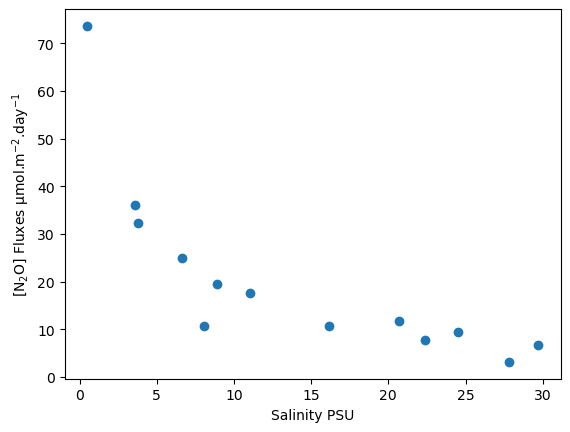

In [102]:
plt.scatter(Smeas, Flux)
plt.xlabel('Salinity PSU')
plt.ylabel('[N$_2$O] Fluxes µmol.m$^{-2}$.day$^{-1}$')